# Finding/opening ACCESS-OM3 `MC_25km_jra_ryf-1.0-beta` test run output using intake

This notebook demonstrates how to using intake-esm to find and load data data from the ACCESS-OM3 `MC_25km_jra_ryf-1.0-beta` test run.

For more information about using intake-esm to find and load data, see:
- the [intake-esm documentation](https://intake-esm.readthedocs.io/en/stable/)
- [this section](https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/quickstart.html#using-an-intake-esm-datastore) of the access-nri-intake-catalog documentation

In [36]:
#This cell must be in all notebooks!
#It allows us to run all the notebooks at once, this cell has a tag "parameters" which allows us to pass in 
# arguments externally using papermill (see mkfigs.sh for details)

# Import my functions
functions_path = os.path.abspath("/home/566/nd0349/access-om3-analysis/functions")
if functions_path not in sys.path:
    sys.path.append(functions_path)
from get_files import *
from plot_settings import *
from fstd import *
from attenuation_models import *
test()

### USER EDIT start
# esm_file = "/g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel/intake_esm_ds.json"
# esm_file = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_nomixing/experiment_datastore.json"
esm_file='/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
esm_file2 = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf/experiment_datastore.json"

# esm_file2 = "/scratch/ps29/nd0349/access-om3/archive/IC4M2-MCW-100km_jra_ryf/experiment_datastore.json"
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

Functions from get_files.py imported!
ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json
Plot folder path:  /g/data/ps29/nd0349/access-om3-figs/


In [37]:
import xarray as xr
import cf_xarray
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client

In [38]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33497 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:36897' processes=14 threads=14, memory=63.00 GiB>

In [39]:
print(client.dashboard_link)

/proxy/33497/status


### Open the intake-esm datastore

In [40]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)


In [41]:
datastore2 = intake.open_esm_datastore(
    esm_file2,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)


### What ocean variables are available at monthly frequency?

In [42]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [43]:
datastore_filtered = datastore.search(realm="ocean", frequency="1mon")

available_variables(datastore_filtered)

variable_long_name  \
variable                                                            
GM_sfn_y        Parameterized Meridional Overturning Streamfun...   
KE                             Layer kinetic energy per unit mass   
Kd_Itidal_Work        Work done by Internal Tide Diapycnal Mixing   
Kd_ePBL                  ePBL diapycnal diffusivity at interfaces   
Kd_interface            Total diapycnal diffusivity at interfaces   
...                                                           ...   
zi                                    Interface pseudo-depth, -z*   
zos                                Sea surface height above geoid   
zos_max                            Sea surface height above geoid   
zos_min                            Sea surface height above geoid   
zossq                    Square of sea surface height above geoid   

                                  variable_standard_name  \
variable                                                   
GM_sfn_y                                                   
KE                                                         
Kd_Itidal_Work                                             
Kd_ePBL                                                    
Kd_interface                                               
...                                                  ...   
zi                                                         
zos                       sea_surface_height_above_geoid   
zos_max                   sea_surface_height_above_geoid   
zos_min                   sea_surface_height_above_geoid   
zossq           square_of_sea_surface_height_above_geoid   

                                        variable_cell_methods variable_units  
variable                                                                      
GM_sfn_y             rho2_i:point yq:point xh:mean time: mean         m3 s-1  
KE              area:mean z_l:mean yh:mean xh:mean time: mean         m2 s-2  
Kd_Itidal_Work  area:mean z_l:mean yh:mean xh:mean time: mean          W m-2  
Kd_ePBL         area:mean zi:point yh:mean xh:mean time: mean         m2 s-1  
Kd_interface    area:mean zi:point yh:mean xh:mean time: mean         m2 s-1  
...                                                       ...            ...  
zi                                                                     meter  
zos                      area:mean yh:mean xh:mean time: mean              m  
zos_max                   area:mean yh:mean xh:mean time: max              m  
zos_min                   area:mean yh:mean xh:mean time: min              m  
zossq                    area:mean yh:mean xh:mean time: mean             m2  

[61 rows x 4 columns]

In [44]:
## Import data

In [55]:
ds1 = datastore.search(variable="mlotst", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
coords = datastore.search(variable=["geolat", "geolon"], #file_id='access_om3_mom6_static'
                         ).to_dask().compute()
coords = coords.fillna(0.0)
ds1 = ds1.assign_coords(coords)
ds1

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid

<xarray.Dataset> Size: 5GB
Dimensions:  (time: 792, yh: 1152, xh: 1440)
Coordinates:
  * xh       (xh) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
  * yh       (yh) float64 9kB -81.03 -81.1 -81.16 -81.23 ... 89.74 89.84 89.95
  * time     (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2023-12-16T12:...
    geolon   (yh, xh) float64 13MB 0.0 0.0 0.0 0.0 0.0 ... 80.0 80.0 80.0 80.0
    geolat   (yh, xh) float64 13MB 0.0 0.0 0.0 0.0 ... 65.37 65.26 65.16 65.05
Data variables:
    mlotst   (time, yh, xh) float32 5GB dask.array<chunksize=(1, 1152, 1440), meta=np.ndarray>
Attributes: (12/15)
    title:                                    ACCESS-OM3
    associated_files:                         areacello: access-om3.mom6.stat...
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['mlotst']
    intake_esm_attrs:file_id:                 ocean.1mon.nv:2.xh:1440.yh:1152
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,ocean_mixed_layer_thickness_...
    intake_esm_attrs:variable_cell_methods:   ,,,area:mean yh:mean xh:mean ti...
    intake_esm_attrs:variable_units:          days,days since 1900-01-01 00:0...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean.1mon.nv:2.xh:1440.yh:1152

In [56]:
ds2 = datastore2.search(variable="mlotst", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
coords = datastore2.search(variable=["geolat", "geolon"], file_id='access_om3_mom6_static'
                          ).to_dask().compute()
coords = coords.fillna(0.0)
ds2 = ds2.assign_coords(coords)
ds2

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 17MB
Dimensions:  (time: 36, yh: 300, xh: 360)
Coordinates:
  * xh       (xh) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yh       (yh) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * time     (time) object 288B 1900-01-16 12:00:00 ... 1902-12-16 12:00:00
    geolon   (yh, xh) float64 864kB 0.0 0.0 0.0 0.0 ... 79.94 79.96 79.97 79.99
    geolat   (yh, xh) float64 864kB 0.0 0.0 0.0 0.0 ... 66.44 66.04 65.63 65.21
Data variables:
    mlotst   (time, yh, xh) float32 16MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/16)
    NumFilesInSet:                            1
    title:                                    ACCESS-OM3
    associated_files:                         areacello: access-om3.mom6.stat...
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['mlotst']
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,ocean_mixed_layer_thickness...
    intake_esm_attrs:variable_cell_methods:   ,,,,area:mean yh:mean xh:mean t...
    intake_esm_attrs:variable_units:          degrees_east,degrees_north,days...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_mom6_2d_mlotst_1mon_...

### Load and plot obs data from DeBoyer Montegut (2023)
https://doi.org/10.17882/91774

In [50]:
# MLDobs = xr.open_dataset('/g/data/av17/access-nri-temporary/OM3/MLD-DeBoyerMontegut2023/mld_dr003_ref10m_v2023.nc')['mld_dr003']
# MLDobs.attrs['units'] = MLDobs.attrs['unit']  # fix so plot works

# TODO: append copy of westernmost data to eastern end to avoid gap in plot

In [51]:
# small BUG: mean of monthly means is not mean of days in that month (eg Feb gets slightly more heavily weighted)
# MLDobs_JFM_mean = MLDobs.isel(time=[0, 1, 2]).mean('time').load()
# MLDobs_JAS_mean = MLDobs.isel(time=[6, 7, 8]).mean('time').load()

## Plot the comparison in MLD

In [57]:
from pathlib import Path

exp1 = Path(esm_file).parent.name
exp2 = Path(esm_file2).parent.name

print(exp1)  # mom6-cice6_ryf_rel
print(exp2)  # IC4M8-MCW-100km_jra_ryf

25km-iaf-test-for-AK-expt-7df5ef4c
IC4M8-MCW-100km_jra_ryf


### Plot against Obs

Text(0.5, 0.98, 'Comparison with observations of 25km-iaf-test-for-AK-expt-7df5ef4c and IC4M8-MCW-100km_jra_ryf')

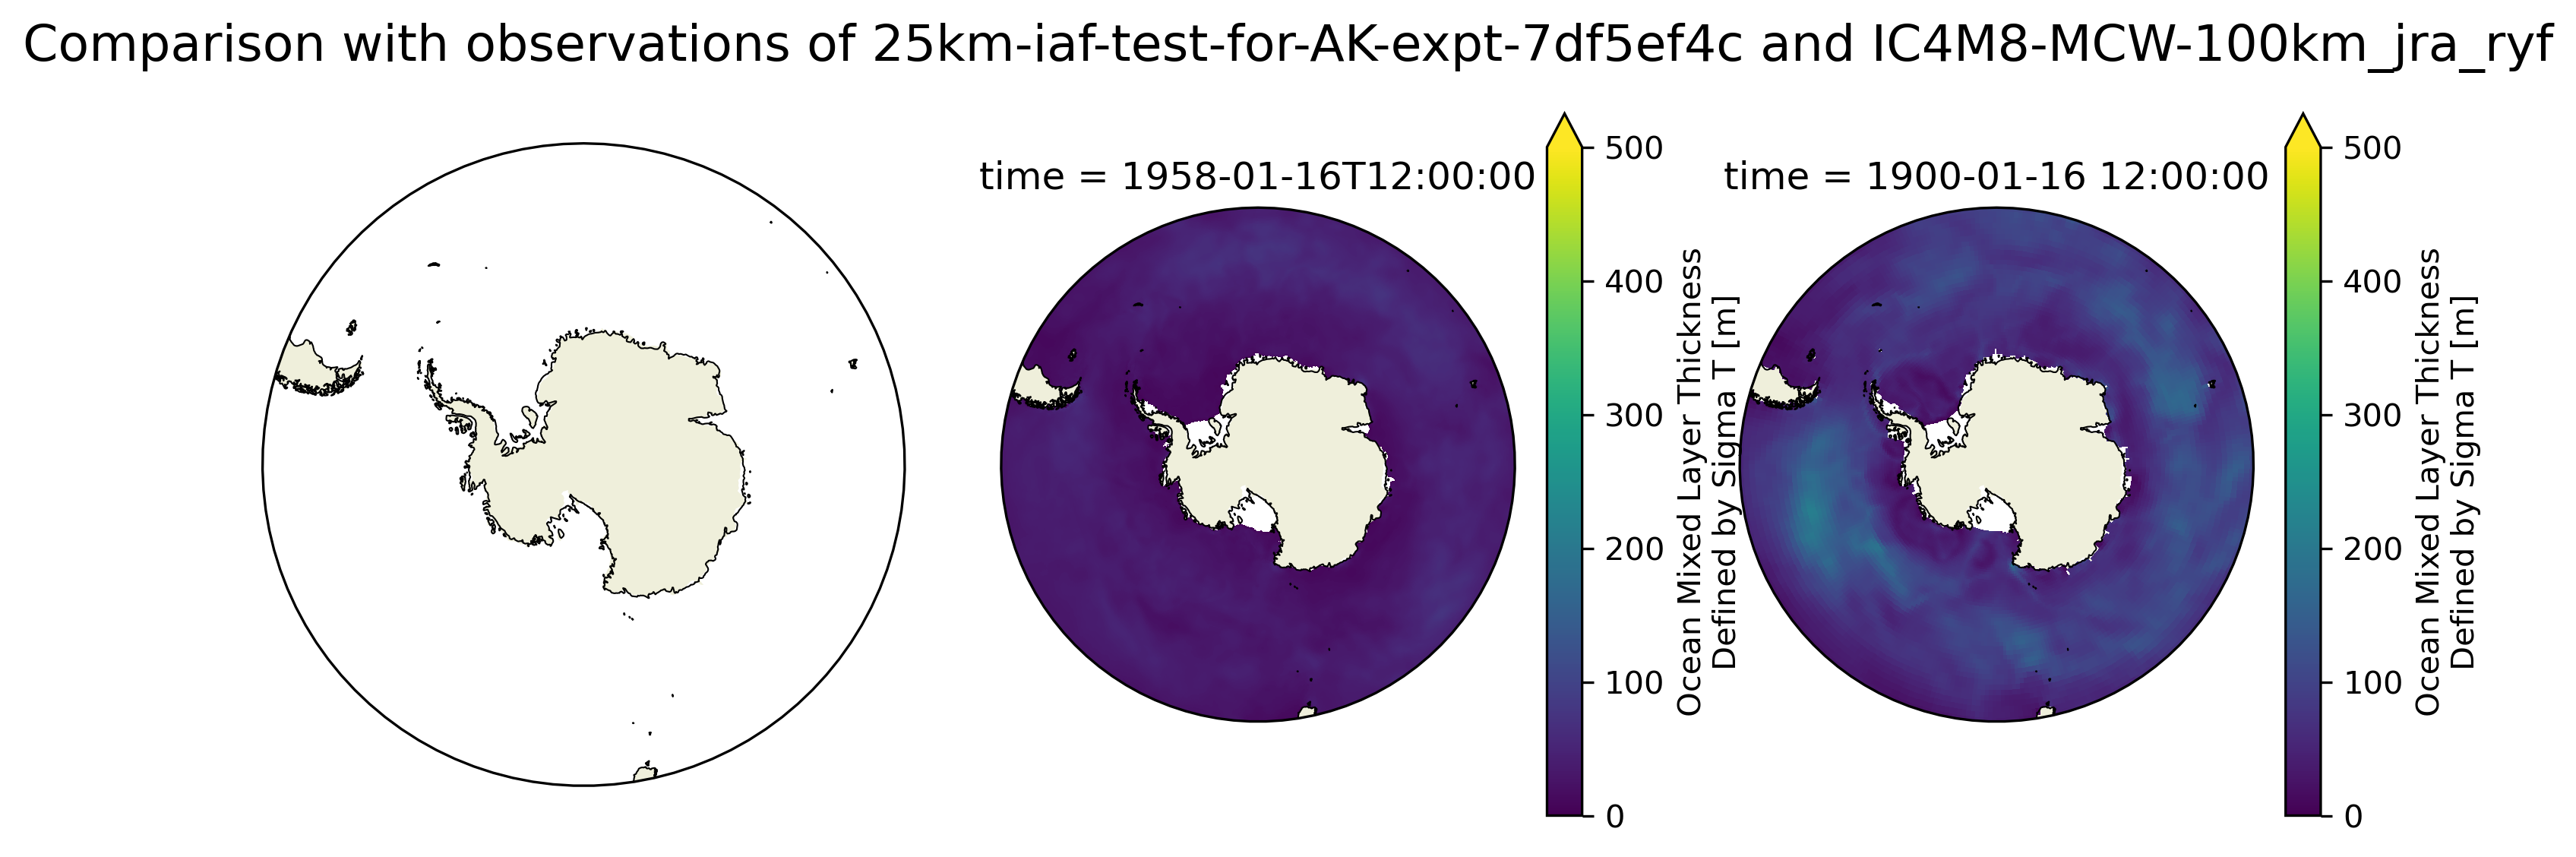

In [63]:
time_idx = 0
hemisphere = "south"
dims = [1, 3]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere)

# settings = get_plot_settings("mlotst")

ds1["mlotst"].isel(time=time_idx).plot(ax=axes[1], x="geolon", y="geolat", 
                    vmin=0,
                    vmax=500,
                    cmap='viridis',
                    transform=ccrs.PlateCarree(),
) 

ds2["mlotst"].isel(time=time_idx).plot(ax=axes[2], x="geolon", y="geolat", 
                    vmin=0,
                    vmax=500,
                    cmap='viridis',
                    transform=ccrs.PlateCarree(),
) 

# diff = ds2["mlotst"].isel(time=time_idx) - ds1["mlotst"].isel(time=time_idx)
# diff = diff.assign_coords(coords)
# diff.plot(ax=axes[2], x="geolon", y="geolat", 
#                     vmin=-abs(diff).max().values,
#                     vmax=abs(diff).max().values,
#                     cmap=cmo.balance,
#                     transform=ccrs.PlateCarree(),
#                     cbar_kwargs={"label": "Difference [m]"} 
# ) 
fig.suptitle(f"Comparison with observations of {exp1} and {exp2}", fontsize=16)

### Plot comparison

ValueError: zero-size array to reduction operation fmax which has no identity

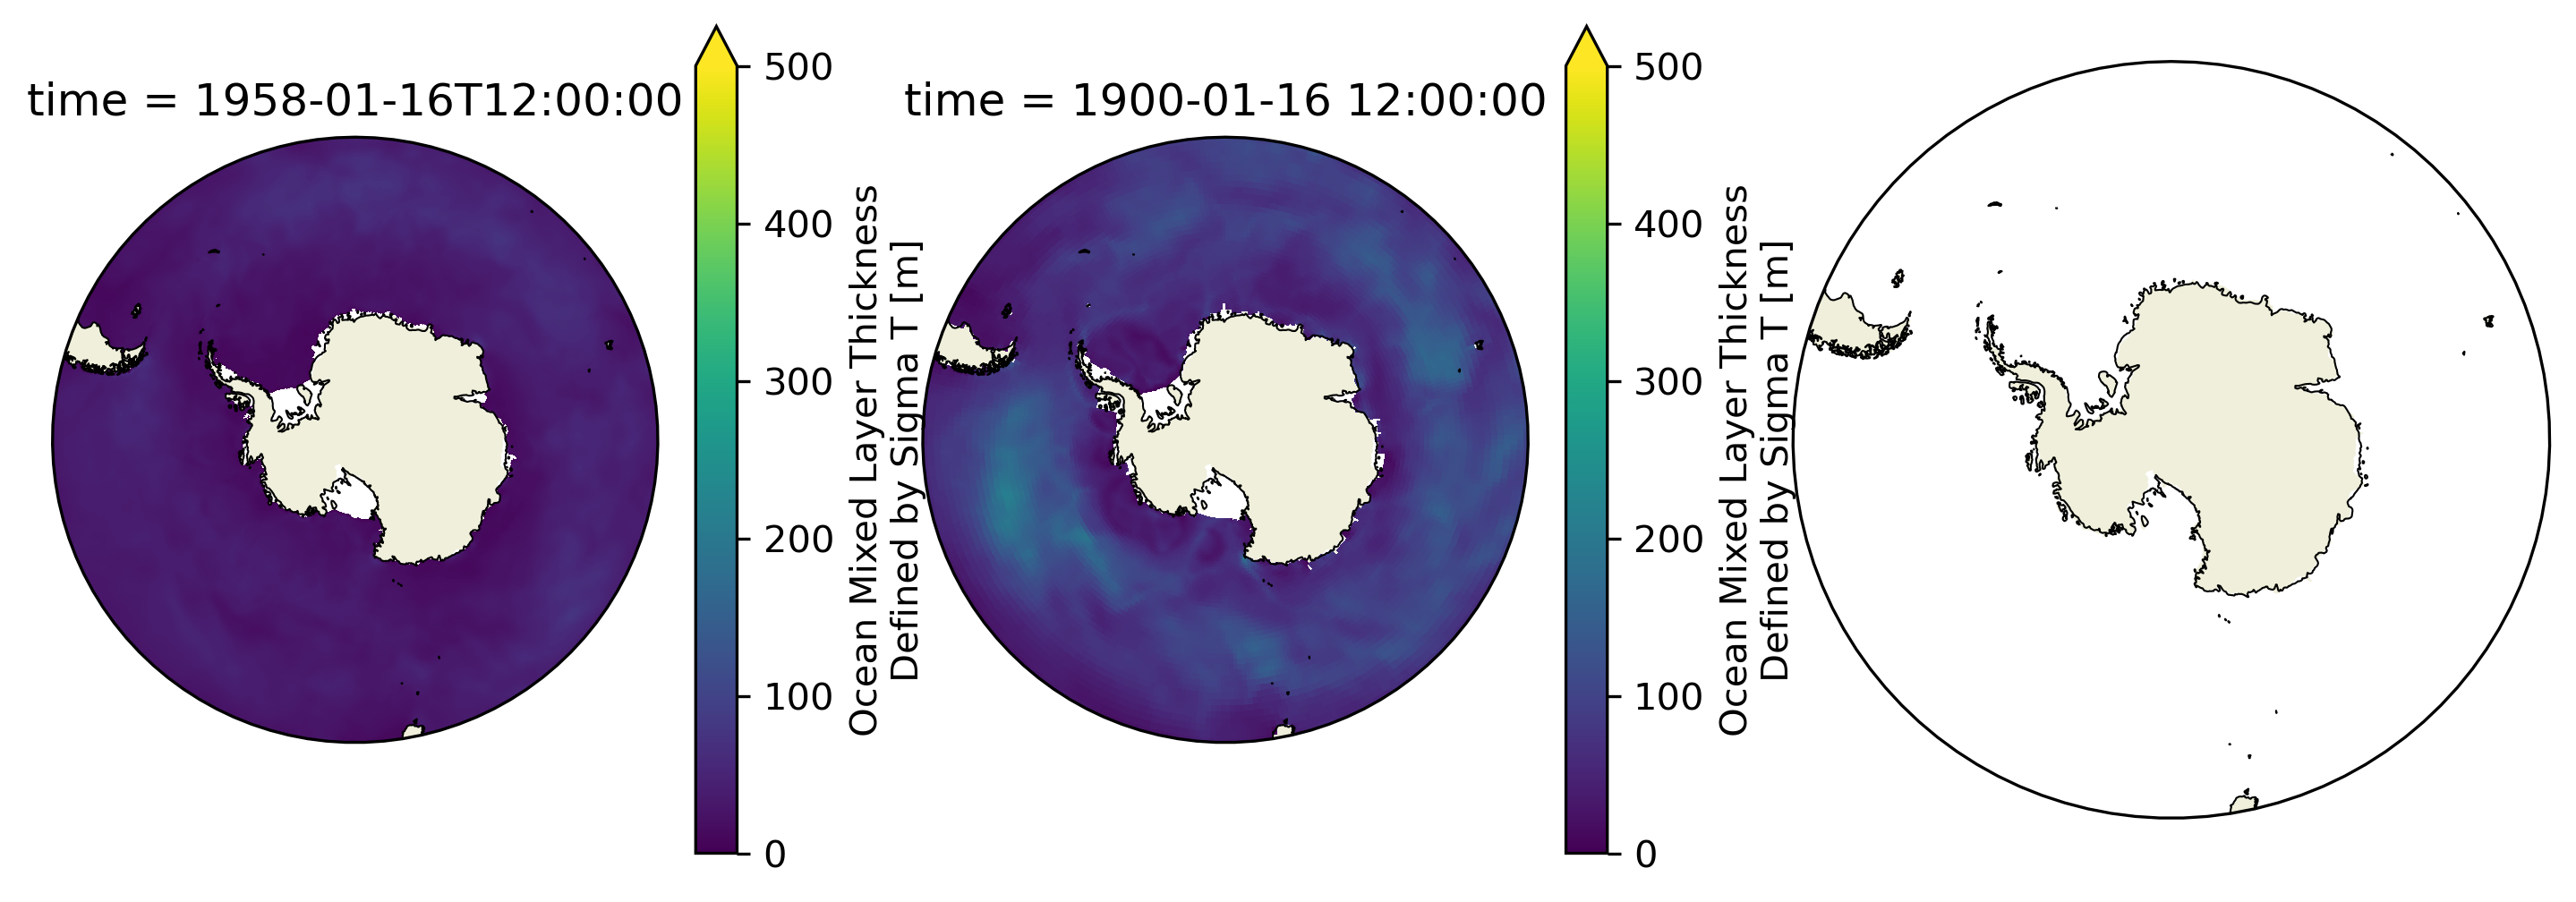

In [53]:
time_idx = 0
hemisphere = "south"
dims = [1, 3]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere)

settings = get_plot_settings("ICE")

ds1["mlotst"].isel(time=time_idx).plot(ax=axes[0], x="geolon", y="geolat", 
                    vmin=0,
                    vmax=500,
                    cmap='viridis',
                    transform=ccrs.PlateCarree(),
) 

ds2["mlotst"].isel(time=time_idx).plot(ax=axes[1], x="geolon", y="geolat", 
                    vmin=0,
                    vmax=500,
                    cmap='viridis',
                    transform=ccrs.PlateCarree(),
) 

diff = ds2["mlotst"].isel(time=time_idx) - ds1["mlotst"].isel(time=time_idx)
diff = diff.assign_coords(coords)
diff.plot(ax=axes[2], x="geolon", y="geolat", 
                    vmin=-abs(diff).max().values,
                    vmax=abs(diff).max().values,
                    cmap=cmo.balance,
                    transform=ccrs.PlateCarree(),
                    cbar_kwargs={"label": "Difference [m]"} 
) 
fig.suptitle(rf"Comparison of {exp1} and {exp2}", fontsize=16)

In [ ]:
datastore.search(variable="aice_m", frequency="1mon")

## Check sea ice conc

In [67]:
ds1 = datastore.search(variable="aice_m", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"nj": -1, "ni": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
coords = datastore.search(variable=["geolat", "geolon"], #file_id='access_om3_mom6_static'
                         ).to_dask().compute()
coords = coords.fillna(0.0)
coords = coords.rename({'xh': 'ni', 'yh': 'nj'})
ds1 = ds1.assign_coords(coords)
ds1

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid

<xarray.Dataset> Size: 11GB
Dimensions:  (time: 792, nj: 1152, ni: 1440)
Coordinates:
  * time     (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2023-12-16T12:...
  * ni       (ni) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
  * nj       (nj) float64 9kB -81.03 -81.1 -81.16 -81.23 ... 89.74 89.84 89.95
    geolon   (nj, ni) float64 13MB 0.0 0.0 0.0 0.0 0.0 ... 80.0 80.0 80.0 80.0
    geolat   (nj, ni) float64 13MB 0.0 0.0 0.0 0.0 ... 65.37 65.26 65.16 65.05
Data variables:
    aice_m   (time, nj, ni) float64 11GB dask.array<chunksize=(1, 1152, 1440), meta=np.ndarray>
Attributes: (12/20)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    time_axis_position:                       middle
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,time: mean,time: mean,,,,,ti...
    intake_esm_attrs:variable_units:          radians,radians,m,C,C,1,1,1,1,1...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   seaIce.1mon.nbnd:2.nc:5.ni:1440...

In [68]:
ds2 = datastore2.search(variable="aice_m", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"ni": -1, "nj": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
coords = datastore2.search(variable=["geolat", "geolon"], file_id='access_om3_mom6_static'
                          ).to_dask().compute()
coords = coords.fillna(0.0)
coords = coords.rename({'xh': 'ni', 'yh': 'nj'})
ds2 = ds2.assign_coords(coords)
ds2

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 33MB
Dimensions:  (time: 36, nj: 300, ni: 360)
Coordinates:
  * time     (time) object 288B 1900-01-16 12:00:00 ... 1902-12-16 12:00:00
  * ni       (ni) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * nj       (nj) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
    geolon   (nj, ni) float64 864kB 0.0 0.0 0.0 0.0 ... 79.94 79.96 79.97 79.99
    geolat   (nj, ni) float64 864kB 0.0 0.0 0.0 0.0 ... 66.44 66.04 65.63 65.21
Data variables:
    aice_m   (time, nj, ni) float64 31MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

ValueError: x must be one of None, 'ni', 'nj', 'time'. Received 'geolon' instead.

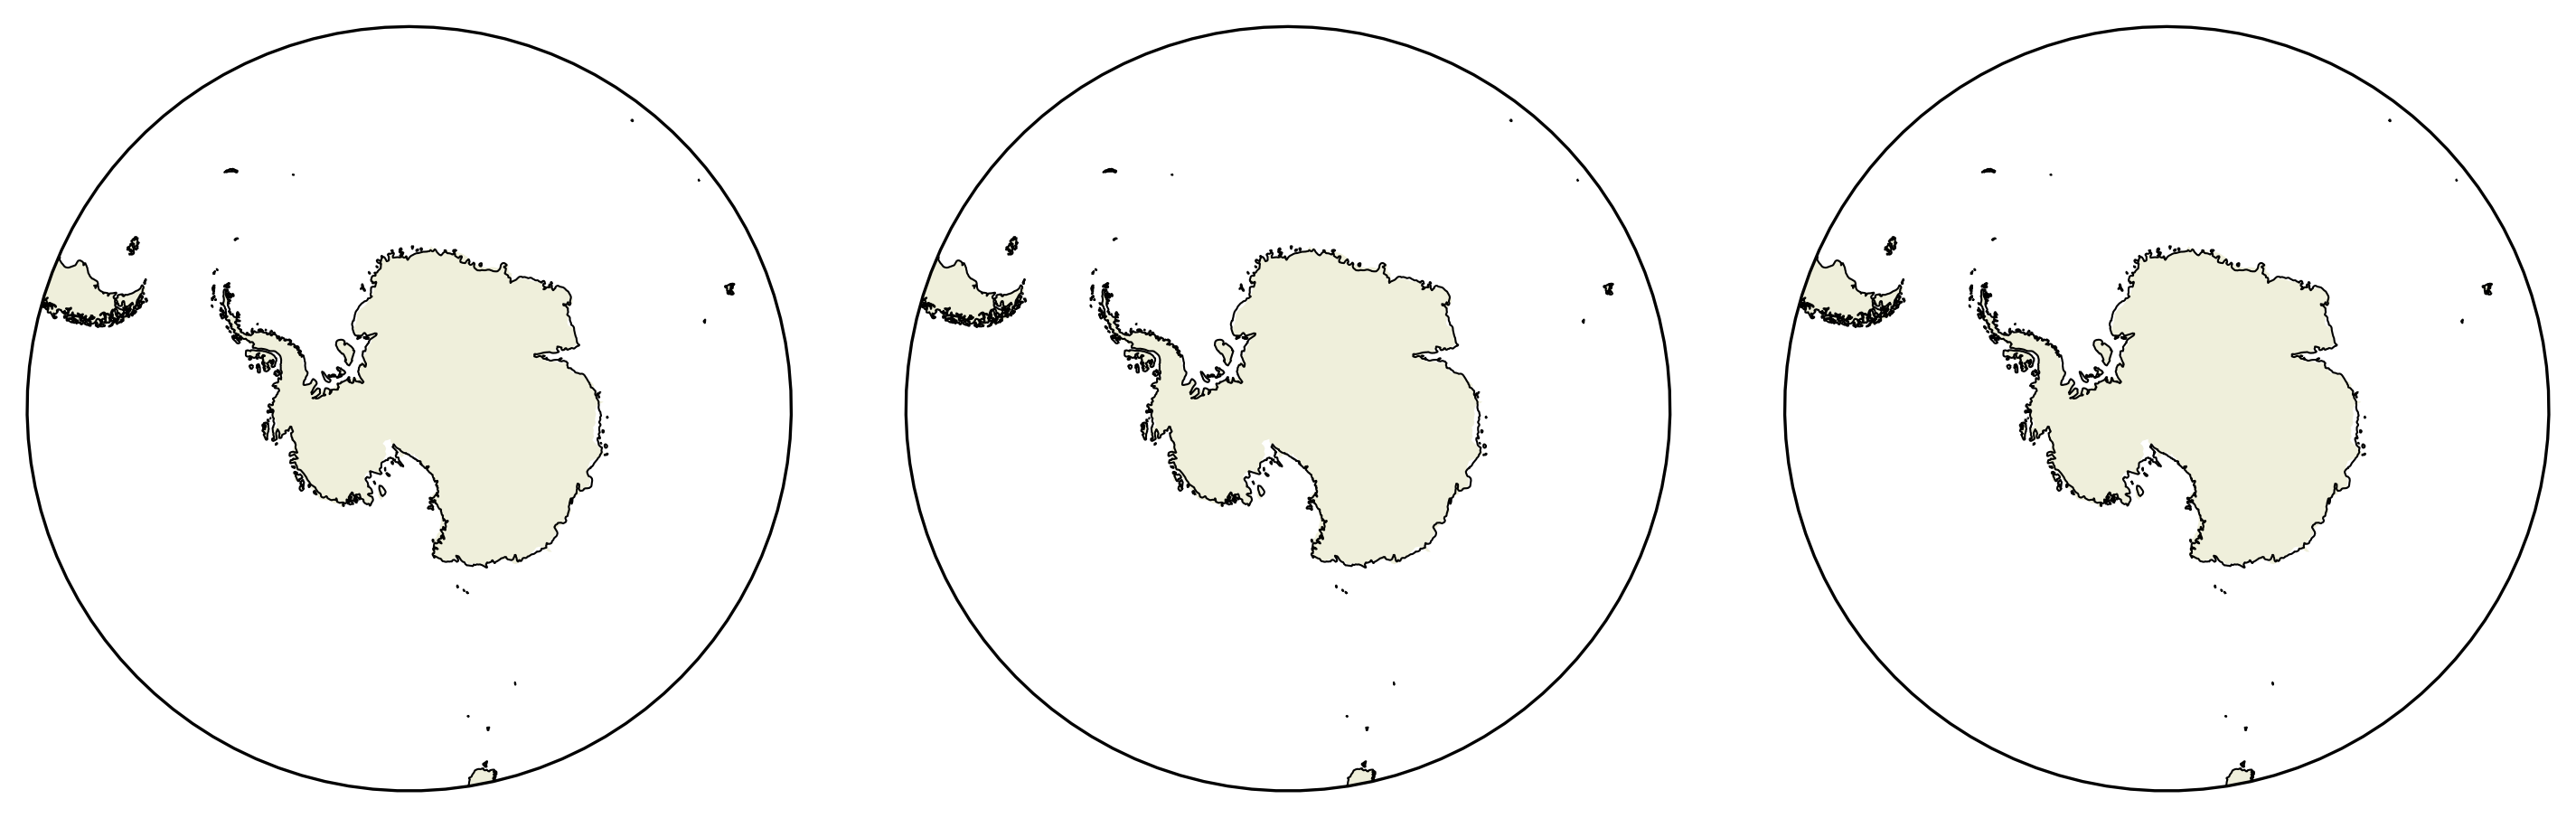

In [66]:
time_idx = 0
hemisphere = "south"
dims = [1, 3]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere)

settings = get_plot_settings("ICE")

ds1["aice_m"].isel(time=time_idx).plot(ax=axes[0], x="geolon", y="geolat", 
                    vmin=0,
                    vmax=1,
                    cmap=cmo.ice,
                    transform=ccrs.PlateCarree(),
) 

ds2["aice_m"].isel(time=time_idx).plot(ax=axes[1], x="geolon", y="geolat", 
                    vmin=0,
                    vmax=1,
                    cmap=cmo.ice,
                    transform=ccrs.PlateCarree(),
) 

# diff = ds2["aice_m"].isel(time=time_idx) - ds1["aice_m"].isel(time=time_idx)
# diff = diff.assign_coords(coords)
# diff.plot(ax=axes[2], x="geolon", y="geolat", 
#                     vmin=-abs(diff).max().values,
#                     vmax=abs(diff).max().values,
#                     cmap=cmo.balance,
#                     transform=ccrs.PlateCarree(),
#                     cbar_kwargs={"label": "Difference [m]"} 
# ) 
fig.suptitle(rf"Comparison of {exp1} and {exp2}", fontsize=16)

Text(0.5, 0.98, 'Comparison of IC4M8-MCW-100km_jra_ryf_nomixing and IC4M8-MCW-100km_jra_ryf')

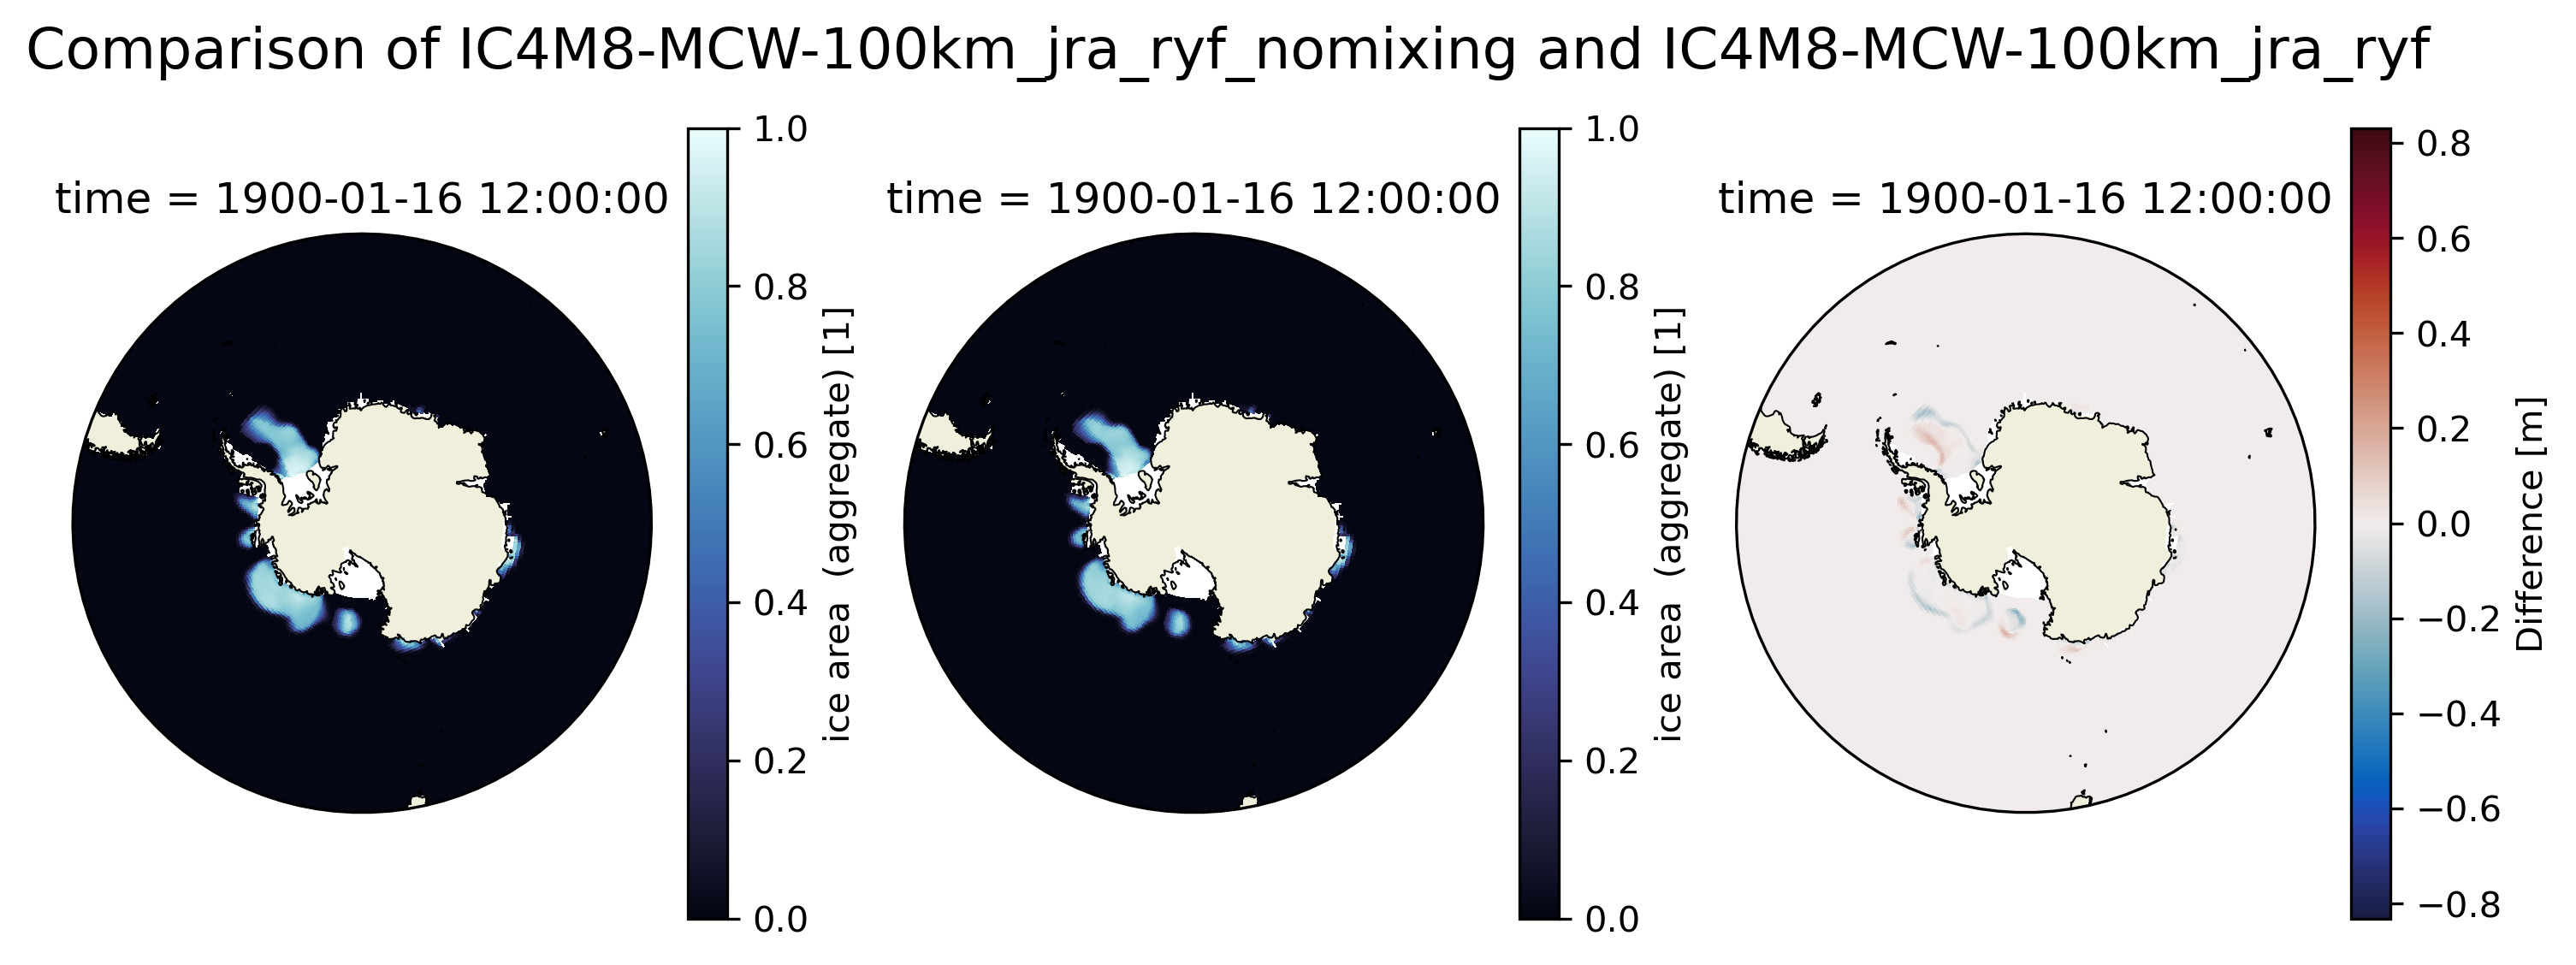

In [31]:
time_idx = 0
hemisphere = "south"
dims = [1, 3]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere)

settings = get_plot_settings("ICE")

ds1["aice_m"].isel(time=time_idx).plot(ax=axes[0], x="geolon", y="geolat", 
                    vmin=0,
                    vmax=1,
                    cmap=cmo.ice,
                    transform=ccrs.PlateCarree(),
) 

ds2["aice_m"].isel(time=time_idx).plot(ax=axes[1], x="geolon", y="geolat", 
                    vmin=0,
                    vmax=1,
                    cmap=cmo.ice,
                    transform=ccrs.PlateCarree(),
) 

diff = ds2["aice_m"].isel(time=time_idx) - ds1["aice_m"].isel(time=time_idx)
diff = diff.assign_coords(coords)
diff.plot(ax=axes[2], x="geolon", y="geolat", 
                    vmin=-abs(diff).max().values,
                    vmax=abs(diff).max().values,
                    cmap=cmo.balance,
                    transform=ccrs.PlateCarree(),
                    cbar_kwargs={"label": "Difference [m]"} 
) 
fig.suptitle(rf"Comparison of {exp1} and {exp2}", fontsize=16)

In [32]:
## And Hi

In [21]:
ds1 = datastore.search(variable="hi_m", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"nj": -1, "ni": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
coords = datastore.search(variable=["geolat", "geolon"], file_id='access_om3_mom6_static'
                         ).to_dask().compute()
coords = coords.fillna(0.0)
coords = coords.rename({'xh': 'ni', 'yh': 'nj'})
ds1 = ds1.assign_coords(coords)
ds1

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 1, nj: 300, ni: 360)
Coordinates:
  * time     (time) object 8B 1900-01-16 12:00:00
  * ni       (ni) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * nj       (nj) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
    geolon   (nj, ni) float64 864kB 0.0 0.0 0.0 0.0 ... 79.94 79.96 79.97 79.99
    geolat   (nj, ni) float64 864kB 0.0 0.0 0.0 0.0 ... 66.44 66.04 65.63 65.21
Data variables:
    hi_m     (time, nj, ni) float64 864kB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/29)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment2:                                 File written on model date 1900...
    comment3:                                 seconds elapsed into model date...
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

In [22]:
ds2 = datastore2.search(variable="hi_m", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"ni": -1, "nj": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
coords = datastore2.search(variable=["geolat", "geolon"], file_id='access_om3_mom6_static'
                          ).to_dask().compute()
coords = coords.fillna(0.0)
coords = coords.rename({'xh': 'ni', 'yh': 'nj'})
ds2 = ds2.assign_coords(coords)
ds2

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 33MB
Dimensions:  (time: 36, nj: 300, ni: 360)
Coordinates:
  * time     (time) object 288B 1900-01-16 12:00:00 ... 1902-12-16 12:00:00
  * ni       (ni) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * nj       (nj) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
    geolon   (nj, ni) float64 864kB 0.0 0.0 0.0 0.0 ... 79.94 79.96 79.97 79.99
    geolat   (nj, ni) float64 864kB 0.0 0.0 0.0 0.0 ... 66.44 66.04 65.63 65.21
Data variables:
    hi_m     (time, nj, ni) float64 31MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

Text(0.5, 0.98, 'Comparison of IC4M8-MCW-100km_jra_ryf_nomixing and IC4M8-MCW-100km_jra_ryf')

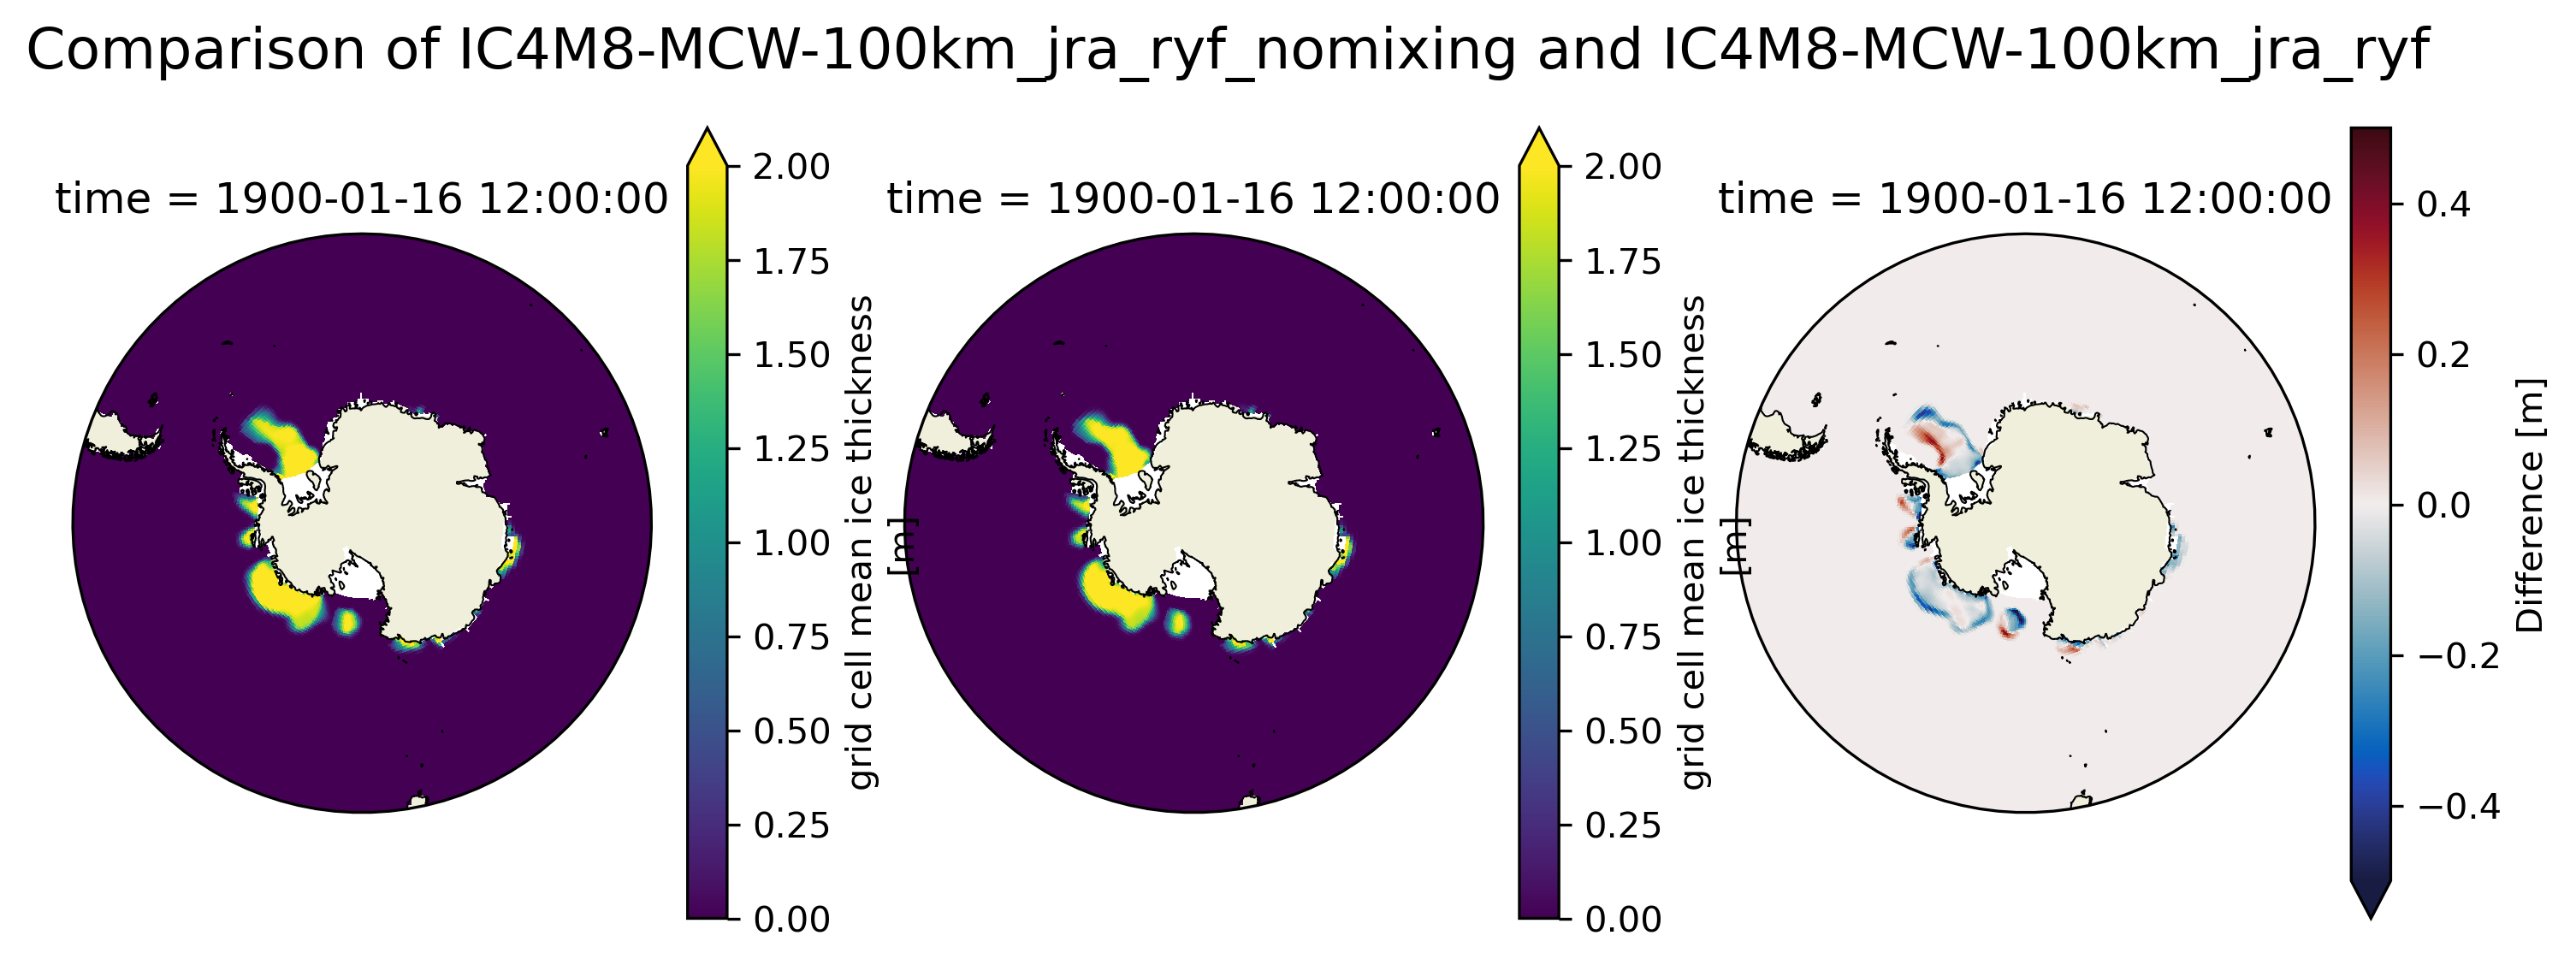

In [23]:
time_idx = 0
hemisphere = "south"
dims = [1, 3]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere)

settings = get_plot_settings("ICE")

ds1["hi_m"].isel(time=time_idx).plot(ax=axes[0], x="geolon", y="geolat", 
                    vmin=0,
                    vmax=2,
                    cmap='viridis',
                    transform=ccrs.PlateCarree(),
) 

ds2["hi_m"].isel(time=time_idx).plot(ax=axes[1], x="geolon", y="geolat", 
                    vmin=0,
                    vmax=2,
                    cmap='viridis',
                    transform=ccrs.PlateCarree(),
) 

diff = ds2["hi_m"].isel(time=time_idx) - ds1["hi_m"].isel(time=time_idx)
diff = diff.assign_coords(coords)
diff.plot(ax=axes[2], x="geolon", y="geolat", 
                    vmin=-0.5, #abs(diff).max().values,
                    vmax=0.5, #abs(diff).max().values,
                    cmap=cmo.balance,
                    transform=ccrs.PlateCarree(),
                    cbar_kwargs={"label": "Difference [m]"} 
) 
fig.suptitle(rf"Comparison of {exp1} and {exp2}", fontsize=16)

### Load monthly sea surface height (`zos`) and plot the field at the last available time

In [7]:
zos = datastore.search(variable="zos", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

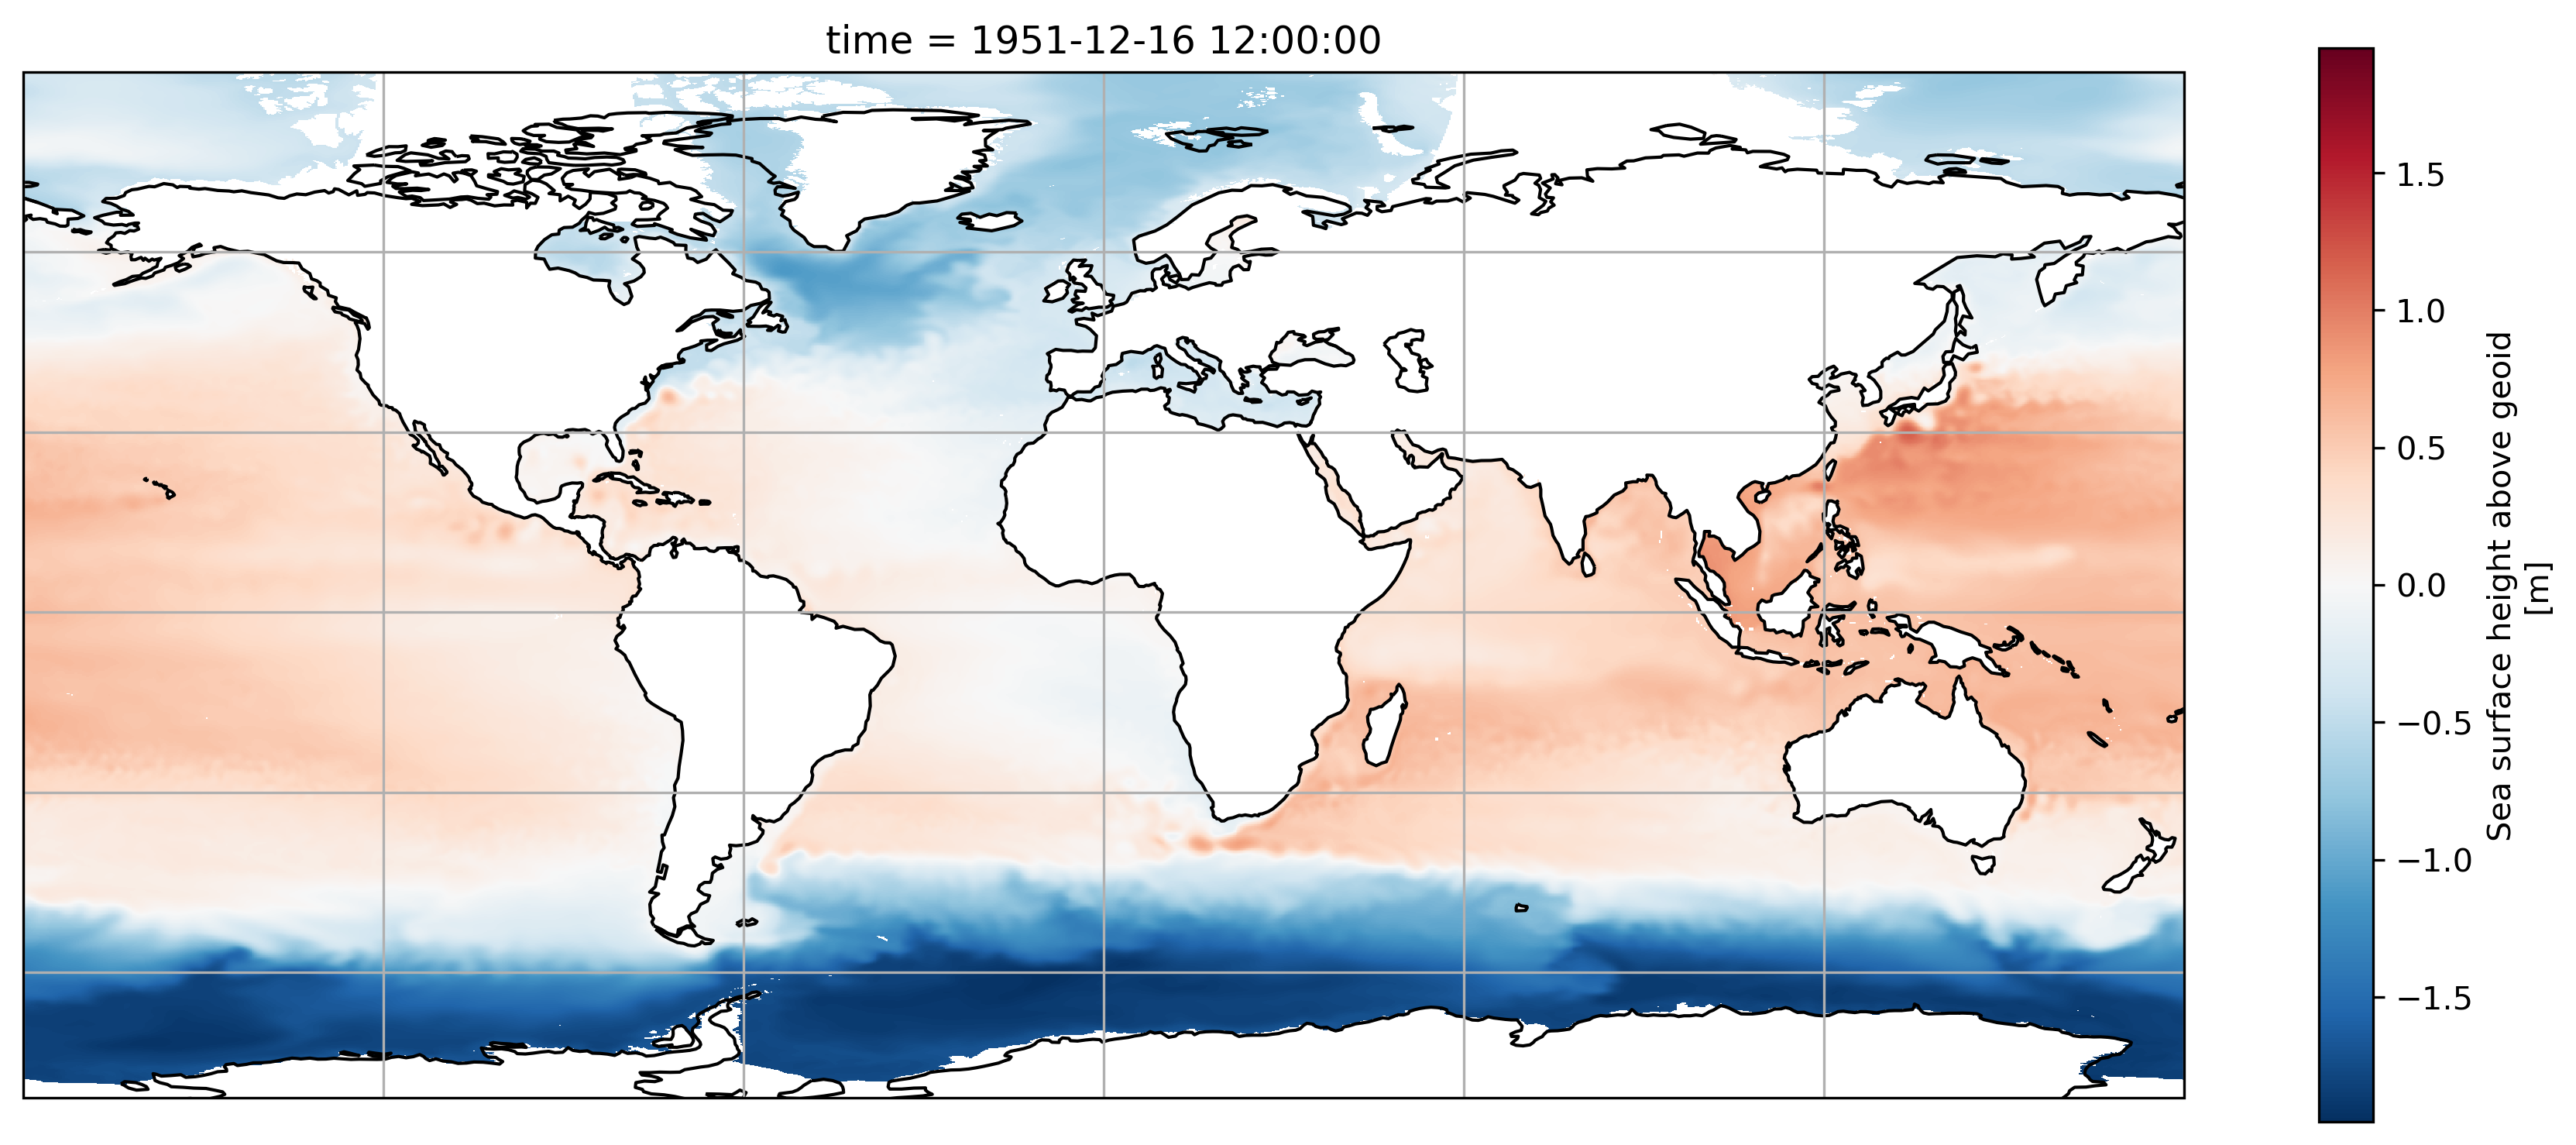

In [8]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

zos["zos"].isel(time=-1).plot(ax=ax)
ax.coastlines()
_ = ax.gridlines()

#### Fixing the plot axes

Notice that the white land-masked regions are distorted away from the coastlines in the Arctic in the above plot. This is because a tripolar grid is used, so the grid lines are not zonal and meridional north of 65N, and consequently the nominal 1D coordinates `xh` and `yh` are incorrect. To fix this we need to use 2d coordinates `geolon` and `geolat`.

We can get these coorindates from the intake-esm datastore. However, note that `geolon` and `geolat` contain NaNs in regions where processors were masked over land. Below we replace these NaNs with zeros so that the coordinates can be used for plotting.

In [9]:
coords = datastore.search(variable=["geolat", "geolon"]).to_dask().compute()
coords = coords.fillna(0.0)

zos = zos.assign_coords(coords)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


In [ ]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

zos["zos"].isel(time=-1).plot(ax=ax, x="geolon", y="geolat")

ax.coastlines()
_ = ax.gridlines()
plt.savefig(plotfolder+'exampleout.png')

In [ ]:
client.close()